In [4]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append(base_dir+'functions/')
from utils import split_retrain
from exp_hp import get_hp

Num GPUs Available:  0


### Load standardized CESM2-LE

8
Training Members: ['0201', '0211', '0221', '0231', '0241', '0251', '0261', '0271', '0281']
Validation Member: 0291
Testing Member: 0301
Lead: 14
Region: 30-60N x 170-240E
loading data & saving
0
240/240 [==============================] - 0s 696us/step
1
240/240 [==============================] - 0s 689us/step
2
240/240 [==============================] - 0s 696us/step
3
240/240 [==============================] - 0s 750us/step
4
240/240 [==============================] - 0s 686us/step
5
240/240 [==============================] - 0s 884us/step
6
240/240 [==============================] - 0s 697us/step
7
240/240 [==============================] - 0s 876us/step
8
240/240 [==============================] - 0s 690us/step
9
240/240 [==============================] - 0s 693us/step


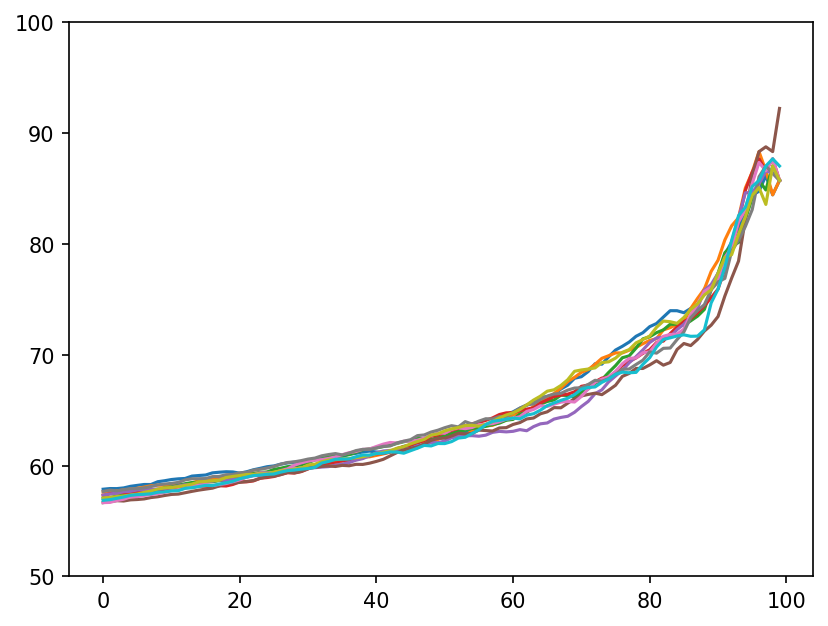

CPU times: user 13.1 s, sys: 1.48 s, total: 14.6 s
Wall time: 16.7 s


In [8]:
%%time
EXP_NAME = 'exp2'
EXP_NAME2 = 'exp2_retrain_increase'
hps = get_hp(EXP_NAME)
hps2 = get_hp(EXP_NAME2)

for i_trainmems in np.arange(8,9):
    print(i_trainmems)
    print('Training Members: '+str(hps2['train_mems'][i_trainmems]))
    print('Validation Member: '+str(hps2['val_mems'][0]))
    print('Testing Member: '+str(hps2['test_mems'][0]))
    print('Lead: '+str(hps2['LEAD']))
    print('Region: '+str(hps2['region'][0])+'N x '+str(hps2['region'][1])+'E')

    _, _, X1test, _, _, Y1test,_ = split_retrain(trainmems = hps2['train_mems'][i_trainmems],
                                                  valmem = hps2['val_mems'][0],
                                                  testmem = hps2['test_mems'][0],
                                                  months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                  lead = hps2['LEAD'])

    X1test = X1test.reshape((X1test.shape[0],X1test.shape[1]*X1test.shape[2]))
    
    
    #----- SET UP & TRAIN NN -----
    GLOBAL_SEED = hps['GLOBAL_SEED']
    np.random.seed(GLOBAL_SEED)
    random.seed(GLOBAL_SEED)
    tf.random.set_seed(GLOBAL_SEED)

    acc_all = []
    for SEED in range(10):
        print(SEED)
        
        annfi_name = 'ann2_60Eshift_'+EXP_NAME2+'.'+str(i_trainmems)+'_ann1-'+EXP_NAME+'_seed'+str(SEED)+'.h5'
        ann = tf.keras.models.load_model(base_dir+'train/saved_models/'+annfi_name)

        pred = ann.predict(X1test)
        acc = []
        predconf = np.max(pred,axis=-1)
        predval  = np.argmax(pred,axis=-1)

        for q in range(100):
            iconf = np.where(predconf >= np.percentile(predconf,q=q))
            icorr = np.where(predval[iconf] == Y1test[iconf])

            acc.append((len(icorr[0])/len(iconf[0]))*100)
        plt.plot(acc)
        plt.ylim(50,100)

        acc_all.append(acc)
    plt.show()
    
    np.save(base_dir+'test/confvsacc/confvsacc_ann2_60Eshift_'+EXP_NAME2+'.'+str(i_trainmems)+'_ann1-'+EXP_NAME+'.npy', acc_all, allow_pickle=True)